In [1]:
import os, sys, psutil

import netket as nk
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp

from tqdm.notebook import tqdm as tq
import itertools
from functools import reduce

from IPython.display import clear_output
import warnings; warnings.simplefilter('ignore')

# Helper functions

In [2]:
# numpy versions
matmap_np = {
    "H": np.array([[1, 1], [1, -1]], dtype=complex) / np.sqrt(2),
    "X": np.array([[0, 1], [1, 0]], dtype=complex),
    "Y": np.array([[0, -1j], [1j, 0]], dtype=complex),
    "Z": np.array([[1, 0], [0, -1]], dtype=complex),
    "I": np.eye(2**1, dtype=complex)
}
# some pre-computed matrices that might be useful for Ising models
matmap_np.update({
    "II": np.eye(2**2, dtype=complex), # this line alone would already do most of the work
    "ZZ": np.kron(matmap_np["Z"], matmap_np["Z"]),
    "IX": np.kron(matmap_np["I"], matmap_np["X"]),
    "XI": np.kron(matmap_np["X"], matmap_np["I"]),
    "III": np.eye(2**3, dtype=complex),
    "IIII": np.eye(2**4, dtype=complex),
    "IIIII": np.eye(2**5, dtype=complex),
    "IIIIII": np.eye(2**6, dtype=complex),
    "IIIIIII": np.eye(2**7, dtype=complex),
    "IIIIIIII": np.eye(2**8, dtype=complex),
    "IIIIIIIII": np.eye(2**9, dtype=complex),
    "IIIIIIIIII": np.eye(2**10, dtype=complex),
})

# sparse versions
matmap_sp = {k: sp.csr_array(v) for k, v in matmap_np.items()}

In [3]:
def mapp(func, *iterables, cb=None, **kwargs):
    """map function that uses tq for progress bar"""
    for i in tq(range(len(iterables[0]))):
        res = func(*[iterable[i] for iterable in iterables], **kwargs)
        if cb is not None:
            cb(res)
        yield res

def imshow(a, figsize=(8,6), cmap='seismic', **pltargs):
    """Uses magic to create pretty images from arrays."""

    if sp.issparse(a):
        a = a.todense()
    else:
        a = np.array(a, copy=False)
    if np.prod(a.shape) == np.max(a.shape):
        a = a.flatten()
    fig = plt.figure(figsize=figsize)
    cmap = plt.get_cmap(cmap)
    if 'vmin' not in pltargs and 'vmax' not in pltargs:
        vmax = np.max(np.abs(a))
        vmin = -vmax
    plt.imshow(a, cmap=cmap, vmin=vmin, vmax=vmax, **pltargs)
    plt.colorbar()

def hist(data, bins=None, xlabel="", title="", density=False):
    def bins_sqrt(data):
        return int(np.ceil(np.sqrt(len(data))))

    plt.figure(figsize=(10,5))

    # bins
    if not bins:
        bins = bins_sqrt(data)
    n, bins, _ = plt.hist(data, bins=bins, density=density)

    # visuals
    plt.title(title)
    plt.ylabel("Density" if density else "Frequency")
    plt.xlabel(xlabel)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["bottom"].set_visible(False)
    return n, bins

def scatter1d(data, xticks=None, alpha=.5, s=500, marker="|", xlim=None, title="", **pltargs):
    """Create only one axis on which to plot the data."""

    fig = plt.figure(figsize=(10,1))
    ax = fig.gca()
    size = np.array(data, copy=False).flatten().shape
    plt.scatter(data, np.zeros(*size), alpha=alpha, marker=marker, s=s, **pltargs)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_yticks([])
    if xticks:
        ax.set_xticks(xticks)
    if title:
        ax.set_title(title)
    if xlim is not None:
        ax.set_xlim(xlim)
    fig.tight_layout()
    plt.show()

def duh(n, precision=2):
    """ Takes a number of bytes and returns a human-readable string with the
    size in bytes, kilobytes, megabytes, or gigabytes.

    Parameters
        n (int): The number of bytes
        precision (int): The number of decimals to use
    """
    for unit in ['B','KB','MB','GB','TB','PB','EB','ZB']:
        if n < 1024.0:
            break
        n /= 1024.0
    decimals = precision - int(n > 99) - int(n > 9) - int(n > 0)
    if decimals < 0 or unit == 'B':
        decimals = 0
    return f"{n:.{decimals}f} {unit}"

def ising_model_graph(graph, J=(-1,1), h=(-1,1), g=(-1,1)):
    """ Takes a graph and generates a Hamiltonian string for it that is compatible with `parse_hamiltonian`. """
    if not isinstance(graph, nk.graph.Graph):
        raise ValueError(f"graph must be a nk.graph.Graph, but is {type(graph)}")
    
    # get the number of qubits
    n_qubits = graph.n_nodes
    # get the edges
    edges = graph.edges()
    # get the coupling matrix
    J = np.array(J)
    if J.shape == ():
        # triangular matrix with all couplings set to J
        J = np.triu(np.ones((n_qubits, n_qubits)), k=1) * J
    elif J.shape == (2,):
        # triangular matrix with all couplings set to a random value in this range
        J = np.triu(np.random.uniform(J[0], J[1], (n_qubits, n_qubits)), k=1)
    elif J.shape == (n_qubits, n_qubits):
        # use the given matrix
        pass
    else:
        raise ValueError(f"J must be a scalar, 2-element vector, or matrix of shape {(n_qubits, n_qubits)}, but is {J.shape}")
    
    # get the longitudinal fields
    if h is not None:
        h = np.array(h)
        if h.shape == ():
            h = np.ones(n_qubits) * h
        elif h.shape == (2,):
            h = np.random.uniform(h[0], h[1], n_qubits)
        elif h.shape == (n_qubits,):
            pass
        else:
            raise ValueError(f"h must be a scalar, 2-element vector, or vector of shape {(n_qubits,)}, but is {h.shape}")
        
    # get the transverse fields
    if g is not None:
        g = np.array(g)
        if g.shape == ():
            g = np.ones(n_qubits) * g
        elif g.shape == (2,):
            g = np.random.uniform(g[0], g[1], n_qubits)
        elif g.shape == (n_qubits,):
            pass
        else:
            raise ValueError(f"g must be a scalar, 2-element vector, or vector of shape {(n_qubits,)}, but is {g.shape}")
        
    # generate the Hamiltonian
    H_str = ''
    # pairwise interactions
    for i, j in edges:
        if J[i,j] != 0:
            H_str += str(J[i,j]) + '*' + 'I'*i + 'Z' + 'I'*(j-i-1) + 'Z' + 'I'*(n_qubits-j-1) + ' + '
    # local longitudinal fields
    if np.any(h):
        H_str += ' + '.join([str(h[i]) + '*' + 'I'*i + 'Z' + 'I'*(n_qubits-i-1) for i in range(n_qubits) if h[i] != 0]) + ' + '
    # local transverse fields
    if np.any(g):
        H_str += ' + '.join([str(g[i]) + '*' + 'I'*i + 'X' + 'I'*(n_qubits-i-1) for i in range(n_qubits) if g[i] != 0]) + ' + '

    return H_str

def parse_hamiltonian(hamiltonian, sparse=False, scaling=1, buffer=None, max_buffer_n=0):
    """Parse a string representation of a Hamiltonian into a matrix representation. The result is guaranteed to be Hermitian.

    Parameters:
        hamiltonian (str): The Hamiltonian to parse.
        sparse (bool): Whether to use sparse matrices (csr_matrix) or dense matrices (numpy.array).
        scaling (float): A constant factor to scale the Hamiltonian by.
        buffer (dict | bool): A dictionary to store calculated chunks in. If `None`, it defaults to the global `matmap_np` or `matmap_sp` (depending on `sparse`). If `False`, the buffer is disabled.
        max_buffer_n (int): The maximum number of qubits for new chunks to store in the buffer. If `0`, no new chunks will be stored in the buffer.

    Returns:
        numpy.ndarray | scipy.sparse.csr_matrix: The matrix representation of the Hamiltonian.

    Example:
    >>> parse_hamiltonian('0.5*(XX + YY + ZZ + II)') # SWAP
    array([[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
           [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j]
           [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j]
           [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j]])
    >>> parse_hamiltonian('-(XX + YY + .5*ZZ) + 1.5')
    array([[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
           [ 0.+0.j  2.+0.j -2.+0.j  0.+0.j]
           [ 0.+0.j -2.+0.j  2.+0.j  0.+0.j]
           [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j]])
    >>> parse_hamiltonian('0.5*(II + ZI - ZX + IX)') # CNOT

    """
    kron = sp.kron if sparse else np.kron
    matmap = matmap_sp if sparse else matmap_np

    if buffer is None or buffer is True:
        buffer = matmap

    def calculate_chunk_matrix(chunk, sparse=False, scaling=1):
        if buffer is False:  # option to disable the buffer
            chunk_matrix = scaling * matmap[chunk[0]]
            for gate in chunk[1:]:
                gate = matmap[gate]
                chunk_matrix = kron(chunk_matrix, gate)
            return chunk_matrix

        if chunk in buffer:
            return buffer[chunk] if scaling == 1 else scaling * buffer[chunk]
        if len(chunk) == 1:
            return matmap[chunk[0]] if scaling == 1 else scaling * matmap[chunk[0]]
        # Check if a part of the chunk has already been calculated
        for i in range(len(chunk)-1, 1, -1):
            for j in range(len(chunk)-i+1):
                subchunk = chunk[j:j+i]
                if subchunk in buffer:
                    # If so, calculate the rest of the chunk recursively
                    before = calculate_chunk_matrix(chunk[:j], sparse=sparse) if j > 0 else 1
                    after = calculate_chunk_matrix(chunk[j+i:], sparse=sparse) if j+i < len(chunk) else 1
                    return scaling * kron(kron(before, buffer[subchunk]), after)
        # If not, calculate the chunk recursively
        first_gate = matmap[chunk[0]]
        rest = calculate_chunk_matrix(chunk[1:], sparse=sparse)
        res = kron(first_gate, rest)
        if len(chunk) <= max_buffer_n: # saving some memory
            buffer[chunk] = res
        return res if scaling == 1 else scaling * res

    # Remove whitespace
    hamiltonian = hamiltonian.replace(" ", "")
    # replace - with +-, except before e
    hamiltonian = hamiltonian \
                    .replace("-", "+-") \
                    .replace("e+-", "e-") \
                    .replace("(+-", "(-")

    # Find parts in parentheses
    part = ""
    parts = []
    depth = 0
    current_part_weight = ""
    for i, c in enumerate(hamiltonian):
        if c == "(":
            depth += 1
            # search backwards for the weight
            weight = ""
            for j in range(i-1, -1, -1):
                if hamiltonian[j] in ["+", "-"]:
                    weight += hamiltonian[j]
                    break
                weight += hamiltonian[j]
            weight = weight[::-1]
            if weight != "":
                current_part_weight = weight
        elif c == ")":
            depth -= 1
        if depth > 0:
            part += c
        if depth == 0 and c == ")":
            part += c
            # reject parts with complex numbers
            try:
                assert complex(part).imag == 0, "Complex coefficients lead to non-hermitian matrices"
            except ValueError:
                pass
            parts.append((current_part_weight, part))
            part = ""
            current_part_weight = ""

    # Replace parts in parentheses with a placeholder
    for i, (weight, part) in enumerate(parts):
        hamiltonian = hamiltonian.replace(weight+part, f"part{i}", 1)
        if weight in ["", "+", "-"]:
            weight += "1"
        if weight[-1] == "*":
            weight = weight[:-1]
        if weight[-1] == "*":
            weight = weight[:-1]
        # Calculate the part recursively
        parts[i] = parse_hamiltonian(part[1:-1], sparse=sparse, scaling=float(weight), buffer=buffer, max_buffer_n=max_buffer_n)

    # Parse the rest of the Hamiltonian
    chunks = hamiltonian.split("+")
    # Remove empty chunks
    chunks = [c for c in chunks if c != ""]
    # If parts are present, use them to determine the number of qubits
    if parts:
        n = int(np.log2(parts[0].shape[0]))
    else: # Use the first chunk to determine the number of qubits
        first_chunk = chunks[0]
        if first_chunk[0] in ["-", "+"]:
            first_chunk = first_chunk[1:]
        try:
            n = len(first_chunk.split("*")[1])
        except IndexError:
            n = len(first_chunk)

    if sparse:
        H = sp.csr_array((2**n, 2**n), dtype=complex)
    else:
        if n > 10:
            raise ValueError(f"Using a dense matrix for a {n}-qubit Hamiltonian is not recommended. Use sparse=True.")
        H = np.zeros((2**n, 2**n), dtype=complex)

    for chunk in chunks:

        # print(chunk, hamiltonian)
        chunk_matrix = None
        if chunk == "":
            continue
        # Parse the weight of the chunk
        try:
            if len(chunk) == n:
                weight = 1
            elif "*" in chunk:
                weight = float(chunk.split("*")[0])
                chunk = chunk.split("*")[1]
            elif "part" in chunk:
                weight = 1
            elif len(chunk) == n+1 and chunk[0] in ["-", "+"]:
                weight = float(chunk[0] + "1")
                chunk = chunk[1:]
            else:
                weight = float(chunk)
                chunk_matrix = weight * np.eye(2**n)
        except ValueError:
                raise ValueError(f"Invalid chunk for size {n}: {chunk}")

        # If the chunk is a part, add it to the Hamiltonian
        if chunk_matrix is not None:
            pass
        elif chunk.startswith("part"):
            chunk_matrix = parts[int(chunk.split("part")[1])]
        else:
            if len(chunk) != n:
                raise ValueError(f"Gate count must be {n} but was {len(chunk)} for chunk \"{chunk}\"")

            chunk_matrix = calculate_chunk_matrix(chunk, sparse=sparse, scaling = scaling * weight)

        # Add the chunk to the Hamiltonian
        # print("chunk", chunk, parts, scaling)
        # print(hamiltonian, "+=", weight, chunk)
        # print(type(H), H.dtype, type(chunk_matrix), chunk_matrix.dtype)
        assert H.shape == chunk_matrix.shape, f"Chunk matrix dtype {chunk_matrix.shape} does not match Hamiltonian dtype {H.shape}. Input: parse_hamiltonian(\"{hamiltonian}\", sparse={sparse}, buffer={buffer}, scaling={scaling})"
        assert H.dtype == chunk_matrix.dtype, f"Chunk matrix dtype {chunk_matrix.dtype} does not match Hamiltonian dtype {H.dtype}. Input: parse_hamiltonian(\"{hamiltonian}\", sparse={sparse}, buffer={buffer}, scaling={scaling})"
        if len(chunks) == 1:
            H = chunk_matrix
        else:
            H += chunk_matrix

    if sparse:
        assert np.allclose(H.data, H.conj().T.data), f"The given Hamiltonian {hamiltonian} is not Hermitian: {H.data}"
    else:
        assert np.allclose(H, H.conj().T), f"The given Hamiltonian {hamiltonian} is not Hermitian: {H}"

    return H

def calculate_rdms(state, n):
    """ Calculate reduced density matrix for each node and each edge in the fully connected graph. """

    # calculate reduced density matrix for each node
    node_rdms = []
    for i in range(n):
        rdm_i = partial_trace(state, i)
        # reshape to a matrix
        node_rdms.append(np.array(rdm_i))
    # calculate reduced density matrix for each edge
    edge_rdms = []
    for i,j in itertools.combinations(range(n), 2):
        rdm_ij = partial_trace(state, [i,j])
        edge_rdms.append(np.array(rdm_ij))
    return np.array(node_rdms), np.array(edge_rdms)

def get_n_qubits(hamiltonian):
    if isinstance(hamiltonian, str):
        H = parse_hamiltonian(hamiltonian, sparse=True)
    elif isinstance(hamiltonian, nk.operator.DiscreteOperator):
        H = hamiltonian.to_sparse().astype(complex)
    else:
        H = hamiltonian
    return int(np.log2(H.shape[0]))

# from https://qiskit.org/documentation/stable/0.35/stubs/qiskit.quantum_info.partial_trace.html
def partial_trace(rho, retain_qubits):
    """Trace out all qubits not specified in `retain_qubits`."""
    rho = np.array(rho)
    n = int(np.log2(rho.shape[0])) # number of qubits

    # pre-process retain_qubits
    if isinstance(retain_qubits, int):
        retain_qubits = [retain_qubits]
    dim_r = 2**len(retain_qubits)

    # get qubits to trace out
    trace_out = np.array(sorted(set(range(n)) - set(retain_qubits)))
    # ignore all qubits >= n
    trace_out = trace_out[trace_out < n]

    # if rho is a state vector
    if len(rho.shape) == 1:
        st  = rho.reshape([2]*n)
        rho = np.tensordot(st, st.conj(), axes=(trace_out,trace_out))
    # if trace out all qubits, just return the normal trace
    elif len(trace_out) == n:
        return np.trace(rho).reshape(1,1) # dim_r is not necessarily 1 here (if some in `retain_qubits` are >= n)
    else:
        assert rho.shape[0] == rho.shape[1], f"Can't trace a non-square matrix {rho.shape}"

        rho = rho.reshape([2]*(2*n))
        for qubit in trace_out:
            rho = np.trace(rho, axis1=qubit, axis2=qubit+n)
            n -= 1         # one qubit less
            trace_out -= 1 # rename the axes (only "higher" ones are left)

    return rho.reshape(dim_r, dim_r)

def edges_from_graph(graph, undirected=False):
    edges = graph.edges()
    edges = np.array(edges).T
    if undirected:
        edges = np.concatenate([edges, edges[:,::-1]], axis=0)
    edges = np.unique(edges, axis=0)  # sorts the edges
    return edges[0], edges[1]

# from https://docs.pennylane.ai/en/stable/code/api/pennylane.pauli_decompose.html
def pauli_decompose(H):
    r"""Decomposes a Hermitian matrix into a linear combination of Pauli operators.

    Args:
        H (array[complex]): a Hermitian matrix of dimension :math:`2^n\times 2^n`.

    Returns:
        tuple[list[float], list[str]]: the coefficients and the Pauli operator strings

    **Example:**

    We can use this function to compute the Pauli operator decomposition of an arbitrary Hermitian
    matrix:

    >>> H = np.array(
    ... [[-2, -2+1j, -2, -2], [-2-1j,  0,  0, -1], [-2,  0, -2, -1], [-2, -1, -1,  0]])
    >>> pauli_decompose(H)
    ([-1.0, -1.5, -0.5, -1.0, -1.5, -1.0, -0.5,  1.0, -0.5, -0.5],
     ['II', 'IX', 'IY', 'IZ', 'XI', 'XX', 'XZ', 'YY', 'ZX', 'ZY'])
    """
    n = int(np.log2(len(H)))
    N = 2**n

    if H.shape != (N, N):
        raise ValueError("The matrix should have shape (2**n, 2**n), for any qubit number n>=1")

    if not np.allclose(H, H.conj().T):
        raise ValueError("The matrix is not Hermitian")

    obs_lst = []
    coeffs = []

    for term in itertools.product(['I', 'X', 'Y', 'Z'], repeat=n):
        term = "".join(term)
        basis_matrix = reduce(np.kron, [matmap_np[i] for i in term])
        coeff = np.trace(basis_matrix @ H) / N  # project H onto the basis matrix
        coeff = np.real_if_close(coeff).item()

        if not np.allclose(coeff, 0):
            coeffs.append(coeff)
            obs_lst.append(term)

    return coeffs, obs_lst

# Generate random ising hamiltonians

## nk.operator.Ising

In [4]:
# Generate random ising hamiltonians
def random_ising_nk(N: int, graph: nk.graph.Graph):
    J = np.random.uniform(-1, 1, size=N) # Coupling constant
    g = np.random.uniform(-1, 1, size=N) # Transverse field
    n = graph.n_nodes
    edges = edges_from_graph(graph)
    hilbert = nk.hilbert.Spin(s=0.5, N=n)
    h = np.zeros(n)
    n_ones = np.ones(n)

    hamiltonians = []
    for i in range(N):
        ising = nk.operator.Ising(
            hilbert=hilbert,
            graph=graph,
            J=J[i], h=g[i]
        )

        # Convert hyperparameters to the right format
        J_i = np.zeros((n, n))
        J_i[edges] = J[i]
    
        hamiltonians.append((ising, {"J": J_i, "h": h, "g": g[i]*n_ones}))
    return hamiltonians

# Generate a random ising hamiltonian
# imshow(random_ising_nk(1, graph=nk.graph.Grid((2,3), pbc=True))[0][0].to_dense())

## ising_model_graph

In [5]:
# Use the ising_model_graph function to generate more general ising models
def random_ising_own(N: int, graph: nk.graph.Graph):
    """ Generates N random ising models on the given graph. """
    n = graph.n_nodes
    J = np.random.uniform(-1, 1, size=(N, n, n))
    # make sure each J is symmetric
    for i in range(N):
        J[i] = (J[i] + J[i].T)/2
        # make sure the diagonal is zero
        J[i] -= np.diag(np.diag(J[i]))
    h = np.random.uniform(-1, 1, size=(N, n))
    g = np.random.uniform(-1, 1, size=(N, n))

    # get the edges for the coupling matrix
    edges = edges_from_graph(graph)

    hamiltonians = []
    for i in range(N):
        H_ising_str = ising_model_graph(graph, J[i], h[i], g[i])

        # create the coupling matrix
        J_i = np.zeros((n, n))
        J_i[edges] = J[i][edges]
    
        hamiltonians.append((H_ising_str, {"J": J_i, "h": h[i], "g": g[i]}))

    return hamiltonians

# This creates a hamiltonian like netket does, but using the ising_model function
def random_ising_own_like_nk(N: int, graph: nk.graph.Graph):
    """ The main differences with generate_random_ising is (1) the coupling and field strengths are everywhere the same and (2) there is no longitudinal local field."""
    J = np.random.uniform(-1, 1, size=N)
    g = np.random.uniform(-1, 1, size=N)
    n = graph.n_nodes
    h = np.zeros(n)
    ones = np.ones(n)

    # get the edges for the coupling matrix
    edges = edges_from_graph(graph)

    hamiltonians = []
    for i in range(N):
        H_ising_str = ising_model_graph(graph, J[i], 0, g[i])

        # create the coupling and field matrices
        J_i = np.zeros((n,n))
        J_i[edges] = J[i]

        hamiltonians.append((H_ising_str, {"J": J_i, "h": h, "g": g[i]*ones}))

    return hamiltonians

# show a random hamiltonian
# imshow(parse_hamiltonian(random_ising_own(N=1, graph=nk.graph.Grid((2,3), pbc=True))[0][0]).real)

## Check equivalence

In [6]:
graph = nk.graph.Grid((2,3), pbc=True)
J = np.random.uniform(-1, 1)
h = np.random.uniform(-1, 1)

# check if the Hilbert space dimension is too large (happens too easily)
H_dim = 2**(graph.n_nodes)
mem_required = H_dim**2 *4
if mem_required > psutil.virtual_memory().available:
    raise ValueError(f"Warning: Large Hilbert space dimension {H_dim}! This would blow up your memory ({duh(mem_required)} bytes required)!")
elif H_dim > 2**11:
    print(f"Warning: Large Hilbert space dimension {H_dim}! This may take a while ({duh(mem_required)} bytes required)!")

# netket version of the Ising model
ising_nk = nk.operator.Ising(
    hilbert=nk.hilbert.Spin(s=0.5, N=graph.n_nodes),
    graph=graph,
    J=J, h=h
).to_dense()
# corresponds to the following special case
H_str = ising_model_graph(graph, J, 0, -h)
ising_own = parse_hamiltonian(H_str).real

np.allclose(ising_nk, ising_own)

True

# Calculate ground state energies

## Exact diagonalization

In [7]:
def diagonalize(hamiltonian, *args):
    if isinstance(hamiltonian, str):
        H = parse_hamiltonian(hamiltonian, sparse=True).real
    elif isinstance(hamiltonian, nk.operator.DiscreteOperator):
        H = hamiltonian.to_sparse()
    else:
        H = hamiltonian

    evals, evecs = sp.linalg.eigsh(H, k=1, which='SA')
    ground_state_energy = evals[0]
    ground_state = evecs[:,0]
    return ground_state_energy, ground_state

### **The actual generation is happening here!!!**

In [8]:
def generate_dataset(hamiltonians, data_path=None):
    """Generate the data set using exact diagonalization. This function does three things:
    1. Diagonalize the given Hamiltonians using exact diagonalization.
    2. Calculate the reduced density matrix of the ground state for each node and each edge in the fully connect graph.
    3. Save the data set to a file specified by data_path (optional).

    Previously generated data set can be extended by passing the path to the existing data set to data_path.
    If `data_path` is passed and data is found, but no Hamiltonians are given, the existing data set is returned.

    Parameters
        hamiltonians: list of 2-tuples, with Hamiltonians to be diagonalized (need to have all the same number dimension) and their hyperparameters
        data_path: path to save the data set

    Returns
        data: structured array containing the data set
    """
    if data_path is not None:
        # add .npy extension if not present
        if not data_path.endswith('.npy'):
            data_path += '.npy'
        if os.path.exists(data_path):
            # load existing data
            data_old = np.load(data_path, allow_pickle=True)
        else:
            os.makedirs(os.path.dirname(data_path), exist_ok=True)
            data_old = None
    if len(hamiltonians) == 0:
        if data_path is not None and data_old is not None:
            return data_old
        else:
            raise ValueError('No Hamiltonians given and no already generated data set found.')

    # get number of qubits
    n = get_n_qubits(hamiltonians[0][0])
    # create a structured array to store the data
    data = np.empty(len(hamiltonians), dtype=[
        ('hamiltonian', 'O'),                 # hamiltonian hyperparameters
        ('energy', 'f8'),                     # ground state energy
        # ('state', 'f8', (2**n,)),           # ground state (warning: blows up the data set size)
        ('node_rdm', 'f8', (n,2,2)),          # reduced density matrix for each node
        ('edge_rdm', 'f8', (n*(n-1)//2,4,4))  # reduced density matrix for each edge
    ])
    for i in tq(range(len(hamiltonians)), desc='Generating data set'):
        # get Hamiltonian
        hamiltonian, hyperparameters = hamiltonians[i]
        # get ground state energy and state
        energy, state = diagonalize(hamiltonian)
        # calculate reduced density matrix for each node and each edge
        if data_path is not None:
            node_rdms, edge_rdms = calculate_rdms(state, n)
            # add data to structured array
            # data[i] = (hyperparameters, energy, state, node_rdms, edge_rdms)
            data[i] = (hyperparameters, energy, node_rdms, edge_rdms)

    if data_path is not None:
        if data_old is not None:
            # merge old and new data
            data = np.concatenate([data_old, data])
            # remove duplicates
            # data = np.unique(data, axis=0)
        np.save(data_path, data)

    return data

Generating data set:   0%|          | 0/100 [00:00<?, ?it/s]

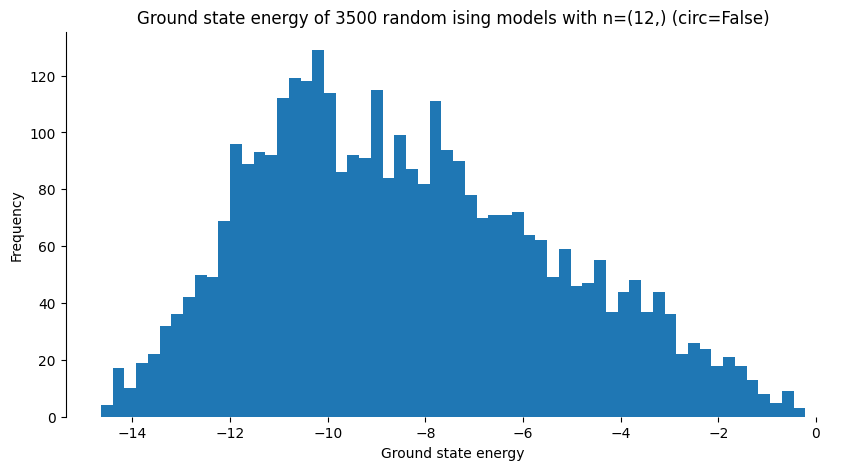

In [9]:
clear_output()
n = (12,)  # System size
          # Timing for exact diagonalization (on M1 chip)
          # (8,) => 34000 / min, (12,) => 1500 / min, (16,) => 100 / min, (20,) => 4 / min
          # (2,4) => 36000 /min, (3,3) => 8000 / min, (3,4) => 1500 / min, (4,4) => 100 / min, (5,4) => 8 / min
          # (2,2,2) => 40000 / min, (2,2,3) => 1500 / min, (2,3,3) => 30 / min
circular = False # Whether to use periodic boundaries
N = 100          # Number of samples to generate

# Generate
graph = nk.graph.Grid(n, pbc=circular)
data = generate_dataset(random_ising_nk(N, graph), data_path=f'data/nk_{n}_{circular}')

# Plot
_ = hist(data['energy'], xlabel="Ground state energy", title=f"Ground state energy of {len(data)} random ising models with n={n} (circ={circular})")

Generating data set:   0%|          | 0/100 [00:00<?, ?it/s]

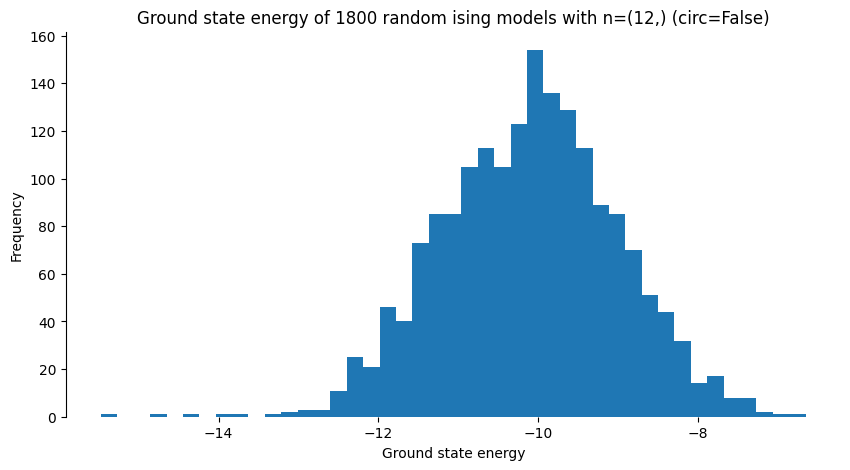

In [10]:
clear_output()
n = (12,)  # System size
          # Timing for exact diagonlization (on M1 chip):
          # (8,) => 9000/min, (10,) => 3000/min, (12,) => 800/min, (14,) => 220/min, (16,) => 55/min
          # (2,2) => 60000/min, (2,3) => 20000/min, (2,4) => 8500/min, (3,3) => 5000/min, (3,4) => 850/min
          # (2,2,2) => 8000/min, (2,2,3) => 700/min, (2,3,3) => 10/min
circular = False  # Circular boundary
N = 100           # Number of samples to generate

# Generate
graph = nk.graph.Grid(n, pbc=circular)
data = generate_dataset(random_ising_own(N, graph), data_path=f'data/own_{n}_{circular}')

# Plot
_ = hist(data['energy'], xlabel="Ground state energy", title=f"Ground state energy of {len(data)} random ising models with n={n} (circ={circular})")

In [11]:
sys.exit() # here to prevent the notebook from running further and destroying the timings and plots when running all cells

SystemExit: 

In [ ]:
# Full procedure for generating the dataset for one hamiltonian
%timeit diagonalize(random_ising_nk(1, nk.graph.Grid((12,), pbc=False))[0][0].to_sparse())
%timeit diagonalize(parse_hamiltonian(random_ising_own(1, nk.graph.Grid((12,), pbc=False))[0][0], sparse=True).real)

39 ms ± 13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
62.5 ms ± 11.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
graph = nk.graph.Grid((8,), pbc=False)

print(f"Abstract Hamiltonian object ({graph.n_nodes} qubits)")
%timeit random_ising_nk(1, graph)
%timeit random_ising_own(1, graph)

print(f"Sparse Hamiltonian matrix ({graph.n_nodes} qubits)")
%timeit random_ising_nk(1, graph)[0][0].to_sparse()
%timeit parse_hamiltonian(random_ising_own(1, graph)[0][0], sparse=True)

H1 = random_ising_nk(1, graph)[0][0].to_sparse()
H2 = parse_hamiltonian(random_ising_own(1, graph)[0][0], sparse=True).real

print(f"Diagonalizing the Hamiltonian ({graph.n_nodes} qubits)")
%timeit diagonalize(H1)
%timeit diagonalize(H2)

graph = nk.graph.Grid((12,), pbc=False)

print(f"Abstract Hamiltonian object ({graph.n_nodes} qubits)")
%timeit random_ising_nk(1, graph)
%timeit random_ising_own(1, graph)

print(f"Sparse Hamiltonian matrix ({graph.n_nodes} qubits)")
%timeit random_ising_nk(1, graph)[0][0].to_sparse()
%timeit parse_hamiltonian(random_ising_own(1, graph)[0][0], sparse=True)

H1 = random_ising_nk(1, graph)[0][0].to_sparse()
H2 = parse_hamiltonian(random_ising_own(1, graph)[0][0], sparse=True).real

print(f"Diagonalizing the Hamiltonian ({graph.n_nodes} qubits)")
%timeit diagonalize(H1)
%timeit diagonalize(H2)

Abstract Hamiltonian object (8 qubits)
39.4 µs ± 278 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
59.2 µs ± 1.85 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Sparse Hamiltonian matrix (8 qubits)
169 µs ± 3.66 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
2.13 ms ± 79.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Diagonalizing the Hamiltonian (8 qubits)
1.14 ms ± 18.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.16 ms ± 6.85 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Abstract Hamiltonian object (12 qubits)
47 µs ± 464 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
75.9 µs ± 684 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Sparse Hamiltonian matrix (12 qubits)
2.79 ms ± 90.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
16.1 ms ± 104 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Diagonalizing the Hamiltonian (12 qubits)
31 ms ± 6.74 ms per loop (mean 

In [ ]:
graph = nk.graph.Grid((8,), pbc=False)
# constructing the abstract representations of the hamiltonians
print(f"Abstract representations ({graph.n_nodes} qubits)")
%timeit len(list(random_ising_nk(N=100, graph=graph)))
%timeit len(list(random_ising_own(N=100, graph=graph)))
# creating the actual matrices
print(f"Matrices ({graph.n_nodes} qubits)")
%timeit len(list(h.to_sparse() for h, _ in random_ising_nk(N=100, graph=graph)))
%timeit len(list(parse_hamiltonian(h, sparse=True) for h, _ in random_ising_own(N=100, graph=graph)))

graph = nk.graph.Grid((12,), pbc=False)
# constructing the abstract representations of the hamiltonians
print(f"Abstract representations ({graph.n_nodes} qubits)")
%timeit len(list(random_ising_nk(N=100, graph=graph)))
%timeit len(list(random_ising_own(N=100, graph=graph)))
# creating the actual matrices
print(f"Matrices ({graph.n_nodes} qubits)")
%timeit len(list(h.to_sparse() for h, _ in random_ising_nk(N=100, graph=graph)))
%timeit len(list(parse_hamiltonian(h, sparse=True) for h, _ in random_ising_own(N=100, graph=graph)))

Abstract representations (8 qubits)
763 µs ± 9.71 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
2.86 ms ± 99.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Matrices (8 qubits)
11.9 ms ± 130 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
207 ms ± 2.65 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Abstract representations (12 qubits)
840 µs ± 2.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
3.69 ms ± 37.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Matrices (12 qubits)
280 ms ± 9.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.75 s ± 47.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Mean field ansatz

In [ ]:
import jax.numpy as jnp
import flax.linen as nn
import json

def save_data(specifier, cb=None):
    path = f"data/data_{specifier}.json"
    def _save(arg):
        if cb is not None:
            key, value = cb(arg)
        else:
            key, value = arg
        # append to json dict
        if os.path.exists(path):
            with open(path, "r") as f:
                data = json.load(f)
        else:
            data = {}
        data[key] = value
        with open(path, "w") as f:
            json.dump(data, f, indent=2)
    return _save

In [ ]:
class MF(nn.Module):

    @nn.compact
    def __call__(self, x):
        """
        Input: x.shape = (n_samples, L)
        Output: log_psi.shape = (n_samples,)
        """
        lam = self.param(
            "lambda", nn.initializers.normal(), (1,), float
        )
        p = nn.log_sigmoid(lam*x)
        return 0.5 * jnp.sum(p, axis=-1)
    
def mean_field(hamiltonian, n_samples=1000, n_iter=300, logfile='test', show_progress=False):
    vstate = nk.vqs.MCState(
        sampler=nk.sampler.MetropolisLocal(hamiltonian.hilbert),
        model=MF(),
        n_samples=n_samples,
    )
    optimizer = nk.optimizer.Sgd(learning_rate=0.05)
    gs = nk.driver.VMC(hamiltonian, optimizer, variational_state=vstate)
    gs.run(n_iter=n_iter, out=logfile, show_progress=show_progress)
    energy = vstate.expect(hamiltonian)
    # Check if converged
    if np.abs(energy.R_hat - 1) > 0.1:
        print('Not converged!', energy)
        return str(hamiltonian), np.nan

    return str(hamiltonian), float(energy.mean)

Ising(J=-0.8897347017710067, h=-0.4943595877530902; dim=12)


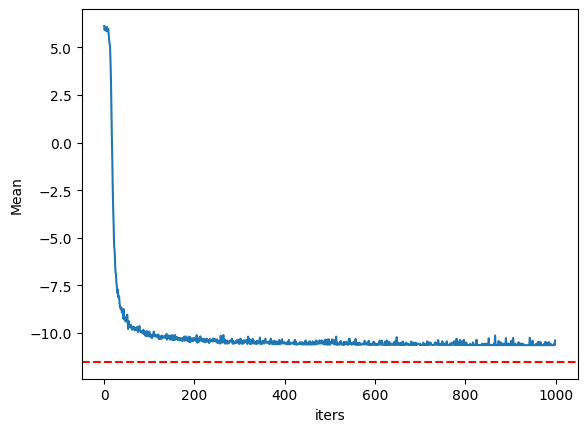

In [ ]:
clear_output()
def plot_json(filename, y, x, exact_energy):
    import json
    with open(filename) as f:
        data = json.load(f)
    data = data["Energy"]
    plt.plot(data[x], data[y])
    plt.axhline(exact_energy, color='r', linestyle='--')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

hamiltonian = generate_nk_ising(1, 12)[0][0]
print(hamiltonian)
mean_field(hamiltonian, n_samples=1000, n_iter=1000, logfile='test', show_progress=True)
# Also calculate exact energy
exact_energy = sp.linalg.eigsh(hamiltonian.to_sparse().astype(complex), k=1, which='SA')[0][0]
# Read JSON from "test.log" and plot "Energy.mean" against "Energy.iters"
plot_json('test.log', 'Mean', 'iters', exact_energy)

`n_iter == 300` seems like a good choice

## VMC (Jastrow)

In [ ]:
class Jastrow(nn.Module):

    @nn.compact
    def __call__(self, x):
        """
        Input: x.shape = (n_samples, L)
        Output: log_psi.shape = (n_samples,)
        """
        lam1 = self.param(
            "lambda1", nn.initializers.normal(), (1,), float
        )
        lam2 = self.param(
            "lambda2", nn.initializers.normal(), (1,), float
        )
        # compute the nearest-neighbor correlations
        corr1=x*jnp.roll(x,-1,axis=-1)
        corr2=x*jnp.roll(x,-2,axis=-1)

        # sum the output
        return jnp.sum(lam1*corr1+lam2*corr2,axis=-1)

def jastrow(hamiltonian, n_samples=1000, n_iter=30, logfile='test', show_progress=False):
    vstate = nk.vqs.MCState(
        sampler=nk.sampler.MetropolisLocal(hamiltonian.hilbert),
        model=Jastrow(),
        n_samples=n_samples,
    )
    optimizer = nk.optimizer.Sgd(learning_rate=0.05)
    gs = nk.driver.VMC(hamiltonian, optimizer, variational_state=vstate)
    gs.run(n_iter=n_iter, out=logfile, show_progress=show_progress)
    energy = vstate.expect(hamiltonian)
    # Check if converged
    if np.abs(energy.R_hat - 1) > 0.1:
        print('Not converged!', energy)
        return str(hamiltonian), np.nan

    return str(hamiltonian), float(energy.mean)

Ising(J=-0.10029482123926003, h=0.21623077672457747; dim=12)


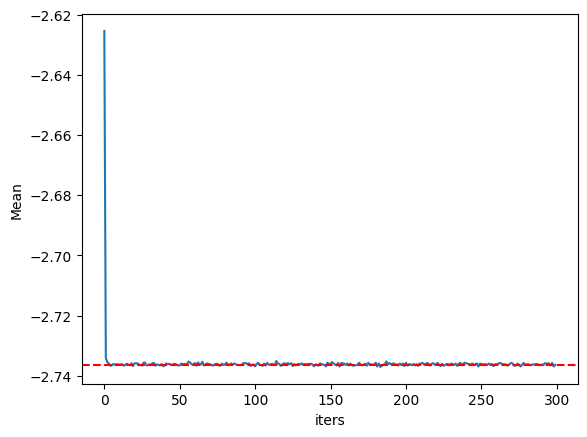

In [ ]:
clear_output()
def plot_json(filename, y, x, exact_energy):
    import json
    with open(filename) as f:
        data = json.load(f)
    data = data["Energy"]
    plt.plot(data[x], data[y])
    plt.axhline(exact_energy, color='r', linestyle='--')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

hamiltonian = generate_nk_ising(1, 12)[0][0]
print(hamiltonian)
jastrow(hamiltonian, n_samples=1000, n_iter=300, logfile='test', show_progress=True)
# Also calculate exact energy
exact_energy = sp.linalg.eigsh(hamiltonian.to_sparse().astype(complex), k=1, which='SA')[0][0]
# Read JSON from "test.log" and plot "Energy.mean" against "Energy.iters"
plot_json('test.log', 'Mean', 'iters', exact_energy)

If it converges, it usually takes `10-20` iterations.

## Grand comparison

In [ ]:
exact_energies = {}
mean_field_energies = {}
jastrow_energies = {}

  0%|          | 0/1000 [00:00<?, ?it/s]

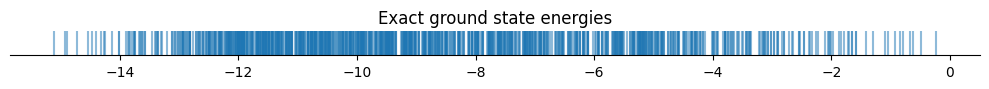

  0%|          | 0/100 [00:00<?, ?it/s]

Not converged! -5.937e+00 ± nan [σ²=0.000e+00, R̂=inf]
Not converged! -1.163e+01 ± nan [σ²=0.000e+00, R̂=inf]


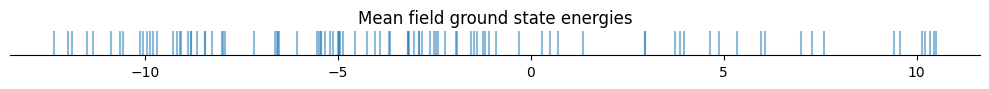

  0%|          | 0/1000 [00:00<?, ?it/s]

Not converged! -2.256e+00 ± 5.595e-17 [σ²=1.775e-30, R̂=1.1103]
Not converged! -9.198e+00 ± 1.119e-16 [σ²=3.155e-30, R̂=1.3757]
Not converged! -2.9097 ± 0.0029 [σ²=0.0085, R̂=1.1078]
Not converged! -1.020e+01 ± nan [σ²=2.840e-29, R̂=1.1546]
Not converged! -6.200e+00 ± nan [σ²=0.000e+00, R̂=inf]
Not converged! -8.612 ± 0.014 [σ²=0.211, R̂=1.1057]
Not converged! -3.439e+00 ± nan [σ²=0.000e+00, R̂=inf]
Not converged! -8.912 ± 0.015 [σ²=0.227, R̂=1.2374]
Not converged! -1.190e+01 ± nan [σ²=0.000e+00, R̂=inf]
Not converged! -1.085e+01 ± 0.000e+00 [σ²=2.840e-29, R̂=1.1564]
Not converged! -7.268 ± 0.029 [σ²=0.847, R̂=1.2071]
Not converged! -5.315e+00 ± 2.797e-17 [σ²=7.889e-31, R̂=1.1312]
Not converged! -0.659 ± 0.064 [σ²=4.183, R̂=1.2952]
Not converged! -8.611e+00 ± 3.357e-16 [σ²=2.840e-29, R̂=1.1093]
Not converged! -1.105e+01 ± nan [σ²=0.000e+00, R̂=inf]
Not converged! -1.147 ± 0.043 [σ²=1.863, R̂=1.2572]
Not converged! -9.416 ± 0.019 [σ²=0.369, R̂=1.1418]
Not converged! -4.965e+00 ± 1.958e-

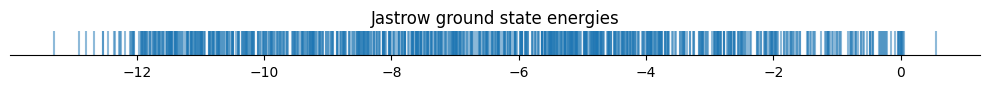

In [ ]:
clear_output()

N = 1000
L = 12
name = "12nk"
hamiltonians_test = random_ising_nk(N, graph=nk.graph.Grid((L,)))

if L <= 23: # Max size with 16GB RAM
    exact_energies[name] = mapp(diagonalize, hamiltonians_test)
    scatter1d([e for e,s in exact_energies[name]], title='Exact ground state energies')

mean_field_energies[name] = mapp(mean_field, hamiltonians_test[::10], cb=save_data(f'mf_{L}'))
scatter1d([e for _,e in mean_field_energies[name]], title='Mean field ground state energies')

jastrow_energies[name] = mapp(jastrow, hamiltonians_test, cb=save_data(f'jastrow_{L}'))
scatter1d([e for _,e in jastrow_energies[name]], title='Jastrow ground state energies')

In [ ]:
sys.exit()

Below this are some generated figures that need quite some time to generate so I didn't want to remove them.

  0%|          | 0/20000 [00:00<?, ?it/s]

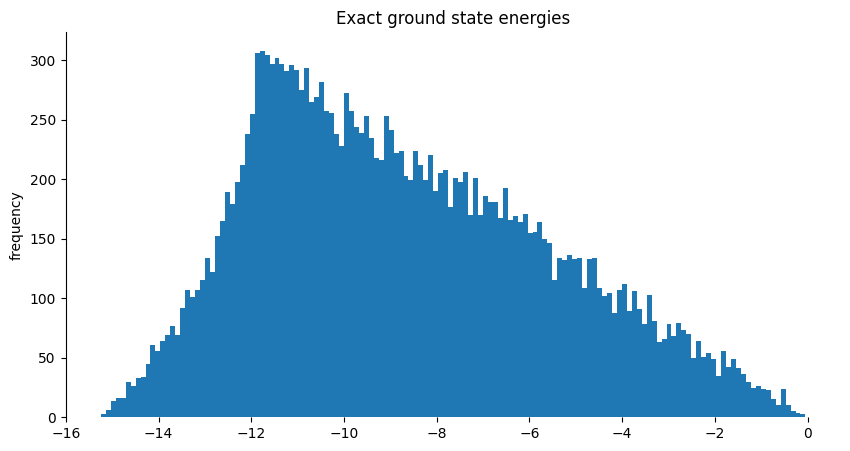

In [ ]:
clear_output()

N = 20000
L = 12
name = "12nk"
hamiltonians_test = random_ising_nk(N, graph=graph=nk.graph.Grid((L,)))

if L <= 23: # Max size with 16GB RAM
    exact_energies[name] = mapp(diagonalize, hamiltonians_test, cb=save_data(f'nk_{L}'))
    hist([e for e,s in exact_energies[name]], title='Exact ground state energies')

  0%|          | 0/20000 [00:00<?, ?it/s]

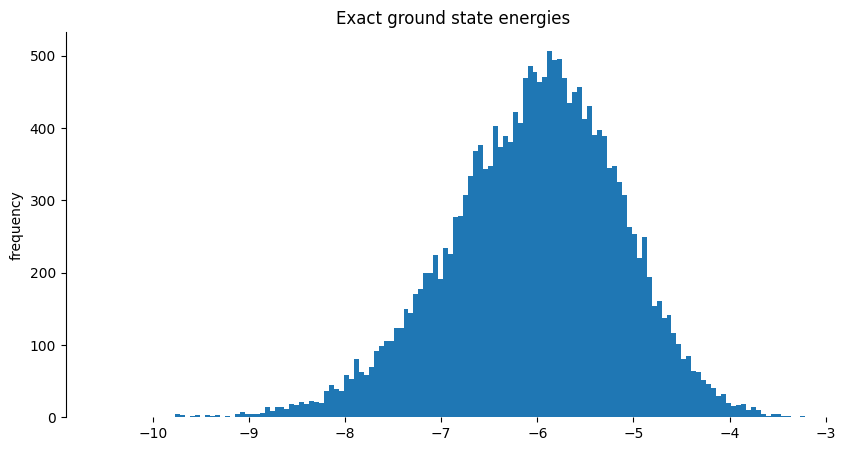

In [ ]:
clear_output()

N = 20000
n = (2,3)
name = "6is"
hamiltonians_test = random_ising_own(N, graph=nk.graph.Grid(n))

if np.prod(n) <= 23: # Max size with 16GB RAM
    exact_energies[name] = mapp(diagonalize, hamiltonians_test) # , cb=save_data(f'{n}')
    hist([e for e,s in exact_energies[name]], title='Exact ground state energies')

  0%|          | 0/200 [00:00<?, ?it/s]

Not converged! -13.44 ± 0.14 [σ²=20.38, R̂=1.3764]
Not converged! -11.915 ± 0.074 [σ²=5.533, R̂=1.3953]
Not converged! -15.159 ± 0.021 [σ²=0.433, R̂=1.1848]
Not converged! -2.688 ± 0.070 [σ²=4.997, R̂=1.2376]
Not converged! -9.771e+00 ± nan [σ²=0.000e+00, R̂=inf]
Not converged! -2.454e+01 ± 8.952e-16 [σ²=4.544e-28, R̂=1.1060]
Not converged! -2.456e+01 ± nan [σ²=0.000e+00, R̂=inf]
Not converged! 1.259 ± 0.078 [σ²=6.090, R̂=1.3115]
Not converged! -19.801 ± 0.025 [σ²=0.611, R̂=1.1616]
Not converged! -1.848e+01 ± 2.238e-16 [σ²=5.049e-29, R̂=1.1701]
Not converged! -1.756e+01 ± 4.476e-16 [σ²=5.049e-29, R̂=1.1020]
Not converged! -5.373e+00 ± 8.392e-17 [σ²=7.100e-30, R̂=1.1173]
Not converged! -2.155e+01 ± 6.714e-16 [σ²=2.019e-28, R̂=1.1423]
Not converged! -1.9265 ± 0.0027 [σ²=0.0074, R̂=1.1428]
Not converged! -16.901 ± 0.028 [σ²=0.814, R̂=1.4086]
Not converged! 5.280 ± 0.024 [σ²=0.600, R̂=1.1913]
Not converged! -0.096 ± 0.076 [σ²=5.877, R̂=1.3452]
Not converged! -1.044e+01 ± nan [σ²=3.155e-30,

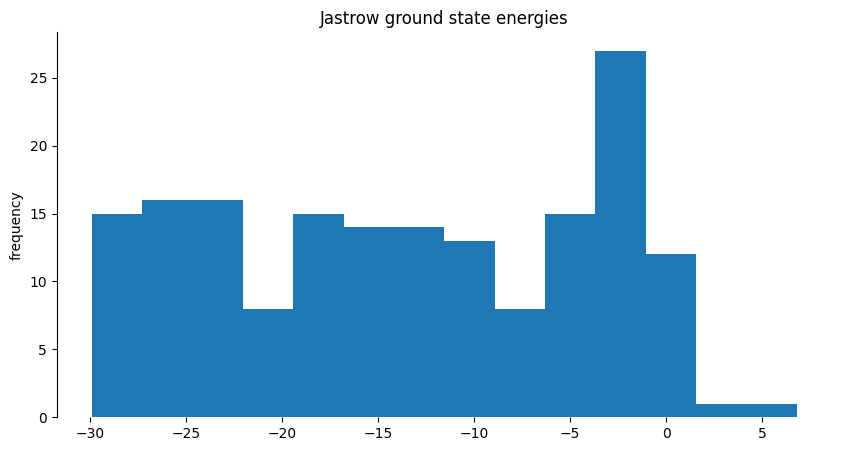

(array([15, 16, 16,  8, 15, 14, 14, 13,  8, 15, 27, 12,  1,  1]),
 array([-29.8924385 , -27.27141012, -24.65038174, -22.02935337,
        -19.40832499, -16.78729662, -14.16626824, -11.54523987,
         -8.92421149,  -6.30318312,  -3.68215474,  -1.06112636,
          1.55990201,   4.18093039,   6.80195876]))

In [ ]:
clear_output()

N = 200
L = 30
name = "30nk"
hamiltonians_test = random_ising_nk(N, graph=nk.graph.Grid((L,)))

jastrow_energies[name] = mapp(jastrow, hamiltonians_test, cb=save_data(f'jastrow_{L}'))
hist([e for e,s in jastrow_energies[name]], title='Jastrow ground state energies')

  0%|          | 0/2000 [00:00<?, ?it/s]

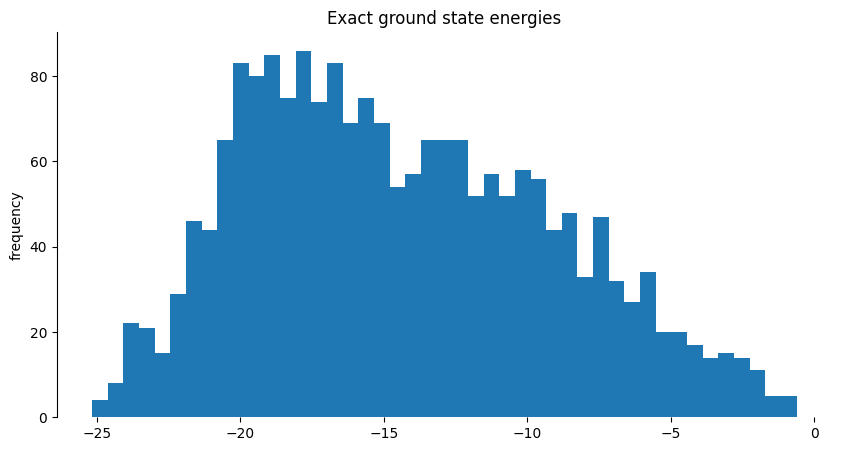

(array([ 4,  8, 22, 21, 15, 29, 46, 44, 65, 83, 80, 85, 75, 86, 74, 83, 69,
        75, 69, 54, 57, 65, 65, 65, 52, 57, 52, 58, 56, 44, 48, 33, 47, 32,
        27, 34, 20, 20, 17, 14, 15, 14, 11,  5,  5]),
 array([-25.16726518, -24.62169113, -24.07611708, -23.53054302,
        -22.98496897, -22.43939492, -21.89382086, -21.34824681,
        -20.80267276, -20.25709871, -19.71152465, -19.1659506 ,
        -18.62037655, -18.0748025 , -17.52922844, -16.98365439,
        -16.43808034, -15.89250628, -15.34693223, -14.80135818,
        -14.25578413, -13.71021007, -13.16463602, -12.61906197,
        -12.07348791, -11.52791386, -10.98233981, -10.43676576,
         -9.8911917 ,  -9.34561765,  -8.8000436 ,  -8.25446954,
         -7.70889549,  -7.16332144,  -6.61774739,  -6.07217333,
         -5.52659928,  -4.98102523,  -4.43545117,  -3.88987712,
         -3.34430307,  -2.79872902,  -2.25315496,  -1.70758091,
         -1.16200686,  -0.6164328 ]))

In [ ]:
clear_output()

N = 2000
L = 20
name = f"{L}nk"
hamiltonians_test = random_ising_nk(N, graph=nk.graph.Grid((L,)))

exact_energies[name] = mapp(diagonalize, hamiltonians_test, cb=save_data(f'nk_{L}'))
hist([e for e,s in exact_energies[name]], title='Exact ground state energies')

## Inspect generated data
(only for the old json format)

** 25649 entries **
-0.048	Ising(J=-0.0023830287088391078, h=-0.0036259028799132675; dim=12)
-0.067	Ising(J=-0.005372007939111079, h=-0.00199769177451925; dim=12)
-0.098	Ising(J=-0.00406869368904994, h=0.007618276772120236; dim=12)
-0.151	Ising(J=0.006803878281625764, h=0.011576980778128076; dim=12)
-0.162	Ising(J=0.007532350518863806, h=-0.012336536584942603; dim=12)
-0.171	Ising(J=-0.006998030814555634, h=-0.013288901364894912; dim=12)
-0.188	Ising(J=0.013791444166151079, h=-0.009916519386437894; dim=12)
-0.217	Ising(J=0.006394337019399288, h=-0.017488638099401932; dim=12)
-0.233	Ising(J=0.006455496170406194, h=-0.01883834643085458; dim=12)
-0.300	Ising(J=-0.024215757167517893, h=0.008527348382344035; dim=12)


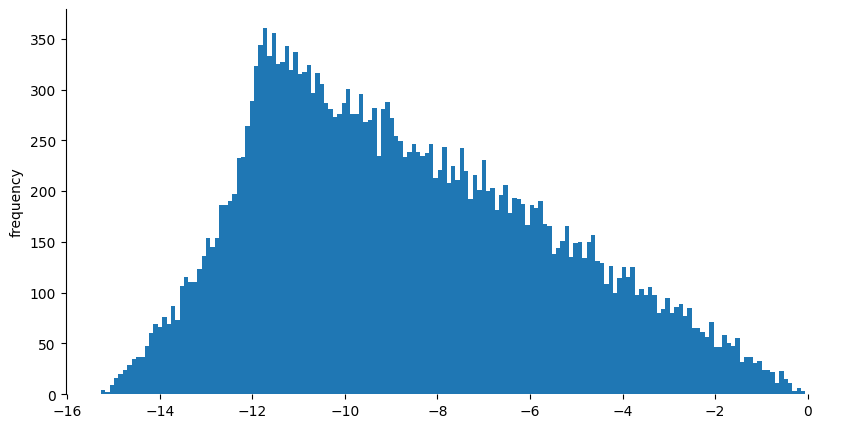

In [ ]:
# with open('data/data_jastrow_30.json', 'r') as f:
with open('data/data_nk_12.json', 'r') as f:
# with open('data/data_(2, 3).json', 'r') as f:
    data = json.load(f)
    # sort by energy
    data_s = sorted(data.items(), key=lambda x: x[1] if not np.isnan(x[1]) else -np.inf)
    print("**",len(data), "entries **")
    for H, E0 in data_s[::-1][:10]:
        print(f"{E0:>3.3f}\t{H}")
    hist(list(data.values()))